# 📈 Stock Selling Policy Evaluation

This model simulates the optimal timing to sell a single asset **only once** over a finite time horizon. It is adapted from Chapter 2 of Warren B. Powell’s *Sequential Decision Analytics and Modeling: Modeling with Python*, and introduces the following enhancements:

- ✅ **Recursive Least Squares (RLS)** estimator to learn price dynamics online  
- ✅ **Historical S&P 500 data** as the price signal  
- ✅ **Monte Carlo evaluation** across many historical windows for robust policy comparison

The goal is to **select the policy** that maximizes expected return over real data.

---

## 🔁 Sequential Decision Flow

```text
            +-----------------------------+
            |     Initial state S₀        |
            |  (R₀ = 1, p₀, p₋₁, p₋₂)      |
            +-------------+---------------+
                          |
                          v
            +-----------------------------+
            |   Observe state Sₜ          |
            +-----------------------------+
                          |
                          v
            +-----------------------------+
            |   Make decision xₜ          |
            |   (Sell = 1, Wait = 0)      |
            +-----------------------------+
                          |
                          v
            +-----------------------------+
            |  Observe price Wₜ₊₁         |
            |  Compute next price pₜ₊₁    |
            +-----------------------------+
                          |
                          v
            +-----------------------------+
            |  Transition to new state Sₜ₊₁ |
            +-----------------------------+
```

---

## 🧱 Model Components

### 📌 State Variables (with Recursive Learning and 3 Price Lags)

Let:

- $R_t \in \{0, 1\}$: Whether the asset is still held (1) or sold (0)  
- $p_t$: Current price  
- $p_{t-1}, p_{t-2}$: Two previous prices  
- $\bar{\theta}_t = (\bar{\theta}_{t,0}, \bar{\theta}_{t,1}, \bar{\theta}_{t,2}) \in \mathbb{R}^3$: RLS estimate of AR coefficients  
- $M_t \in \mathbb{R}^{3 \times 3}$: Covariance matrix of parameter uncertainty

Then:

$$
S_t = \left( R_t, p_t, p_{t-1}, p_{t-2}, \bar{\theta}_t, M_t \right)
$$

---

### 🎯 Decision Variable

Let:

$$
x_t =
\begin{cases}
1 & \text{Sell the asset at time } t \\
0 & \text{Wait}
\end{cases}
\quad \text{subject to } x_t \leq R_t
$$

---

### 🎲 Exogenous Information

We assume the price evolves as:

$$
p_{t+1} = \bar{\theta}_{t,0} p_t + \bar{\theta}_{t,1} p_{t-1} + \bar{\theta}_{t,2} p_{t-2} + \varepsilon_{t+1}
$$

where $\varepsilon_{t+1} \sim \mathcal{N}(0, \sigma^2)$ is not observed.

Instead, we treat:

$$
W_{t+1} = p_{t+1}
$$

as the observable exogenous input and use it to **update the RLS model**.

---

### 🔁 Transition Function (Recursive Learning)

Let:

$$
\phi_t = \begin{bmatrix} p_t \\ p_{t-1} \\ p_{t-2} \end{bmatrix}
$$

Then update the state via:

- Resource:
  $$
  R_{t+1} = R_t - x_t
  $$

- Prediction:
  $$
  \hat{p}_{t+1} = \bar{\theta}_t^\top \phi_t
  $$

- Error:
  $$
  \varepsilon_{t+1} = p_{t+1} - \hat{p}_{t+1}
  $$

- Covariance update:
  $$
  \gamma_t = 1 + \phi_t^\top M_t \phi_t
  $$
  $$
  M_{t+1} = M_t - \frac{1}{\gamma_t} M_t \phi_t \phi_t^\top M_t
  $$

- Parameter update:
  $$
  \bar{\theta}_{t+1} = \bar{\theta}_t + \frac{1}{\gamma_t} M_{t+1} \phi_t \varepsilon_{t+1}
  $$

Final state:

$$
S_{t+1} = \left( R_{t+1}, p_{t+1}, p_t, p_{t-1}, \bar{\theta}_{t+1}, M_{t+1} \right)
$$

---

### 💸 Contribution Function

Reward only occurs if asset is sold:

$$
C(S_t, x_t) = p_t \cdot x_t
$$

---

### 🧮 Objective Function

Since the asset can only be sold once, the problem reduces to:

$$
\max_{\pi} \mathbb{E} \left[ p_\tau \right]
\quad \text{where } \tau = \min \{ t \mid x_t = 1 \}
$$

---

## 🧪 Monte Carlo Evaluation on Historical Data

To evaluate a policy $\pi$:

- We sample **many random time windows** from historical S&P 500 prices  
- In each window, the model simulates over $T$ days  
- A fresh RLS model is used per trial  
- **No artificial noise is injected** — only historical prices

We compute:

- Mean reward across all trials:
  $$
  \bar{F}^\pi = \frac{1}{N} \sum_{n=1}^{N} p_{\tau_n}^{(n)}
  $$

- Optionally, 95% confidence intervals using Central Limit Theorem

This enables **fair policy comparison** using realistic price patterns.


In [19]:
import yfinance as yf
from utils.RecursiveLeastSquares import RecursiveLeastSquares
import numpy as np
from typing import Callable, Tuple
from sklearn.base import BaseEstimator
from copy import deepcopy
from scipy.stats import sem

## Get Data

In [20]:
sp500 = yf.Ticker("^GSPC")
sp500_2024 = sp500.history(start="2024-01-01", end="2025-01-01")

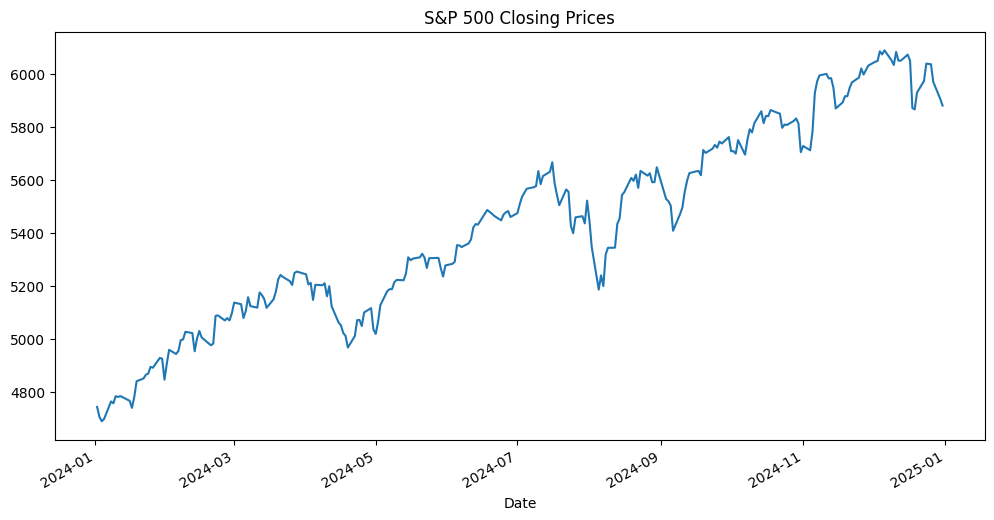

In [21]:
sp500_2024["Close"].plot(title="S&P 500 Closing Prices", figsize=(12, 6));

## Implement

### Initilize Recursive Least Squares and Get Historical Price Array

In [22]:
rls = RecursiveLeastSquares(n_features = 3, delta = 1e3, lambda_ = 1.0)

In [23]:
price_history = sp500_2024["Close"].values

### Define Recursive Least Squares Predict/Update Functions

In [24]:
def rls_predict(
    rls_model: RecursiveLeastSquares,
    p_t: float,
    p_t_1: float,
    p_t_2: float
) -> float:
    """
    Predicts the next price using the current RLS model.

    Args:
        rls_model (RecursiveLeastSquares): The RLS estimator object.
        p_t (float): Price at time t.
        p_t_1 (float): Price at time t-1.
        p_t_2 (float): Price at time t-2.

    Returns:
        float: Predicted price at time t+1.
    """    
    # Construct feature vector (shape: [1, 3]), containing three previous prices.
    x_t = np.array([[p_t, p_t_1, p_t_2]])
    
    # Make prediction for next time step
    return rls_model.predict(x_t)

def rls_update(
    rls_model: RecursiveLeastSquares,
    p_t: float,
    p_t_1: float,
    p_t_2: float,
    p_t_plus_1: float
) -> None:
    """
    Updates the RLS model with observed data from time t.

    Args:
        rls_model (RecursiveLeastSquares): The RLS estimator object.
        p_t (float): Price at time t.
        p_t_1 (float): Price at time t-1.
        p_t_2 (float): Price at time t-2.
        p_t_plus_1 (float): True observed price at time t+1 from historical data.

    Returns:
        None
    """
    # Construct feature vector (shape: [1, 3]), containing three previous prices.
    x_t = np.array([[p_t, p_t_1, p_t_2]])

    # Update RLS model with actual observed price
    rls_model.partial_fit(x_t, np.array([p_t_plus_1]))

### Define Reward Function

In [25]:
def reward(p_t: float, x_t: int) -> float:
    return p_t * x_t

### Policy Function Approximation (PFA)

Policies are simple rules that map the state to an action:

$$
x_t = X^\pi(S_t \mid \theta)
$$

Examples:

- **Sell-Low**:
  $$
  x_t = 
  \begin{cases}
  1 & \text{if } p_t < \theta \text{ and } R_t = 1 \\
  1 & \text{if } t = T \text{ and } R_t = 1 \\
  0 & \text{otherwise}
  \end{cases}
  $$

- **High-Low**:
  $$
  x_t = 
  \begin{cases}
  1 & \text{if } p_t < \theta_{\text{low}} \text{ or } p_t > \theta_{\text{high}} \\
  1 & \text{if } t = T \text{ and } R_t = 1 \\
  0 & \text{otherwise}
  \end{cases}
  $$

- **Tracking Signal**:
  $$
  \bar{p}_t = (1 - \alpha) \bar{p}_{t-1} + \alpha \hat{p}_t
  $$
  $$
  x_t = 
  \begin{cases}
  1 & \text{if } p_t > \bar{p}_t + \theta \\
  1 & \text{if } t = T \text{ and } R_t = 1 \\
  0 & \text{otherwise}
  \end{cases}
  $$

In [26]:
def sell_low_strategy(p_t: float, R_t: int, t: int, T: int, **kwargs) -> int:
    """
    Sell if price is below a threshold, or at final time step.

    Kwargs:
        theta (float): Price threshold below which to sell.
    """
    theta = kwargs.get("theta", None)
    if theta is None:
        raise ValueError("Missing required argument 'theta' for sell_low_strategy.")

    if p_t < theta and R_t == 1:
        return 1
    elif t == T and R_t == 1:
        return 1
    else:
        return 0

def rls_momentum_strategy(p_t: float, R_t: int, t: int, T: int, **kwargs) -> int:
    """
    Sell if RLS predicts the price will drop below current price by more than threshold.
    
    Kwargs:
        p_t_plus_1_predicted (float): RLS prediction for next price
        theta (float): Threshold for selling (as fraction of current price)
    """
    p_t_plus_1_predicted = kwargs.get("p_t_plus_1_predicted", p_t)
    theta = kwargs.get("theta", 0.02)  # 2% drop threshold
    
    if R_t == 1:
        # Sell if prediction shows price will drop by more than threshold
        predicted_drop = (p_t - p_t_plus_1_predicted) / p_t
        if predicted_drop > theta:
            return 1
        elif t == T:
            return 1
    return 0
    
def tracking_signal_strategy(p_t: float, R_t: int, t: int, T: int, **kwargs) -> int:
    """
    Sell if price is significantly higher than a smoothed reference.

    Kwargs:
        bar_p_t (float): Smoothed price estimate.
        theta (float): Threshold above smoothed price for selling.
    """
    bar_p_t = kwargs.get("bar_p_t", None)
    theta = kwargs.get("theta", None)
    if bar_p_t is None or theta is None:
        raise ValueError("Missing 'bar_p_t' or 'theta' for tracking_signal_strategy.")

    if R_t == 1:
        if p_t > bar_p_t + theta:
            return 1
        elif t == T:
            return 1
    return 0

def high_low_strategy(p_t: float, R_t: int, t: int, T: int, **kwargs) -> int:
    """
    Sell if price is too low or too high, or at final time step.

    Kwargs:
        theta_low (float): Lower bound.
        theta_high (float): Upper bound.
    """
    theta_low = kwargs.get("theta_low", None)
    theta_high = kwargs.get("theta_high", None)
    if theta_low is None or theta_high is None:
        raise ValueError("Missing 'theta_low' or 'theta_high' for high_low_strategy.")

    if R_t == 1:
        if p_t < theta_low or p_t > theta_high:
            return 1
        elif t == T:
            return 1
    return 0

### Define Simulation Function

In [27]:
def simulate(
    price_history: np.ndarray,
    rls_model: BaseEstimator,
    strategy: Callable,
    strategy_kwargs: dict,
    start_index: int,
    T: int,
    rls_delta: float = 1e3,
    rls_lambda: float = 1.0
) -> float:
    """
    Simulate a single episode of trading using a specified strategy and RLS forecasting.

    Args:
        price_history (np.ndarray): Historical asset prices.
        rls_model (BaseEstimator): RLS estimator with `partial_fit` and `predict`.
        strategy (Callable): Decision policy function.
        strategy_kwargs (dict): Parameters passed to the strategy.
        start_index (int): Start index for the simulation (requires 3 prior prices).
        T (int): Simulation horizon (number of time steps to simulate).
        rls_delta (float): Initial uncertainty parameter for RLS covariance matrix.
        rls_lambda (float): Forgetting factor for RLS (0 < lambda <= 1).

    Returns:
        float: Total reward (price received from the single asset sale).
    """
    # --- Input validation ---
    if start_index < 3:
        raise ValueError(f"start_index must be >= 3 to access 3 prior prices, got {start_index}")
    if start_index + T >= len(price_history):
        raise ValueError(f"Not enough data: start_index + T = {start_index + T} >= {len(price_history)}")

    # --- RLS initialization with specified parameters ---
    rls_model.delta = rls_delta
    rls_model.lambda_ = rls_lambda
    
    if not rls_model._initialized:
        rls_model._initialize()
        init_length = min(3, start_index - 2)
        for i in range(max(3, start_index - init_length), start_index):
            if i + 1 < len(price_history):
                rls_update(
                    rls_model,
                    price_history[i],
                    price_history[i - 1],
                    price_history[i - 2],
                    price_history[i + 1]
                )

    R_t = 1                 # Asset is initially held
    total_reward = 0        # Accumulated reward from selling
    t_end = min(start_index + T, len(price_history) - 1)

    # --- Simulation loop ---
    for t in range(start_index, t_end):
        if t + 1 >= len(price_history):
            break  # Not enough data to continue

        # --- Get lagged price inputs ---
        p_t     = price_history[t]
        p_t_1   = price_history[t - 1]
        p_t_2   = price_history[t - 2]

        # --- Predict next price with RLS ---
        p_t_plus_1_predicted = rls_predict(rls_model, p_t, p_t_1, p_t_2)

        # --- Prepare strategy input ---
        current_step = t - start_index
        updated_kwargs = strategy_kwargs.copy()

        if strategy.__name__ == "rls_momentum_strategy":
            updated_kwargs["p_t_plus_1_predicted"] = p_t_plus_1_predicted

        # --- Make decision: sell (1) or wait (0) ---
        x_t = strategy(p_t, R_t, t=current_step, T=T, **updated_kwargs)
        x_t = min(x_t, R_t)  # Cannot sell more than one unit

        # --- Collect reward and update state ---
        total_reward += reward(p_t, x_t)
        R_t -= x_t

        if R_t == 0:
            break  # Stop simulation after selling

        # --- Update RLS with actual observed price ---
        p_t_plus_1_actual = price_history[t + 1]
        rls_update(rls_model, p_t, p_t_1, p_t_2, p_t_plus_1_actual)

    return total_reward

### Define Monte Carlo Evaluation

In [28]:
def monte_carlo_evaluate(
    price_history: np.ndarray,
    rls_model: BaseEstimator,
    strategy: Callable,
    strategy_kwargs: dict,
    T: int,
    n_trials: int = 100,
    seed: int = 42,
    stride: int = 5,
    return_ci: bool = False,
    rls_delta: float = 1e3,
    rls_lambda: float = 1.0
) -> float | Tuple[float, Tuple[float, float]]:
    """
    Evaluate a trading strategy via Monte Carlo simulation over historical price windows.

    Args:
        price_history (np.ndarray): Historical price data array.
        rls_model (BaseEstimator): RLS estimator to be copied and used per trial.
        strategy (Callable): Policy function mapping state → action.
        strategy_kwargs (dict): Strategy-specific parameters.
        T (int): Simulation horizon (in time steps).
        n_trials (int): Number of episodes to simulate.
        seed (int): Random seed for reproducibility.
        stride (int): Minimum spacing between start indices to reduce overlap.
        return_ci (bool): Whether to return a 95% confidence interval.
        rls_delta (float): Initial uncertainty parameter for RLS covariance matrix.
        rls_lambda (float): Forgetting factor for RLS (0 < lambda <= 1).

    Returns:
        float: Average reward across all trials.
        OR
        Tuple[float, Tuple[float, float]]: (mean, 95% CI) if return_ci=True.
    """
    # --- Check data sufficiency ---
    min_required = 3 + T + 1  # 3 lags + T steps + 1 target price
    if len(price_history) < min_required:
        raise ValueError(f"Price history too short: need at least {min_required} points, got {len(price_history)}")

    np.random.seed(seed)

    # --- Compute eligible start indices with desired stride ---
    valid_indices = np.arange(3, len(price_history) - T - 1, stride)
    actual_trials = min(n_trials, len(valid_indices))

    if actual_trials < n_trials:
        print(f"Warning: Only {actual_trials} trials possible (requested {n_trials})")

    # --- Sample starting points for simulation ---
    sampled_starts = np.random.choice(valid_indices, size=actual_trials, replace=False)

    rewards = []
    failed_trials = 0

    # --- Run simulations ---
    for idx in sampled_starts:
        try:
            rls_copy = deepcopy(rls_model)  # New RLS model per trial
            trial_reward = simulate(
                price_history=price_history,
                rls_model=rls_copy,
                strategy=strategy,
                strategy_kwargs=strategy_kwargs,
                start_index=idx,
                T=T,
                rls_delta=rls_delta,
                rls_lambda=rls_lambda
            )
            rewards.append(trial_reward)
        except Exception as e:
            failed_trials += 1
            print(f"Warning: Trial at index {idx} failed: {e}")

    # --- Check for failure cases ---
    if not rewards:
        raise RuntimeError("All trials failed — no valid reward results.")

    # --- Compute mean reward ---
    mean_reward = np.mean(rewards)

    # --- Optionally compute confidence interval ---
    if return_ci:
        ci_margin = 1.96 * sem(rewards)  # 95% CI via normal approximation
        return mean_reward, (mean_reward - ci_margin, mean_reward + ci_margin)

    return mean_reward

### Define Evaluate Strategies

In [29]:
def evaluate_all_strategies(
    price_history: np.ndarray,
    rls_model: BaseEstimator,
    strategy_configs: list,
    T: int,
    n_trials: int = 100,
    seed: int = 42
) -> list:
    """
    Evaluate multiple trading strategies over historical price data.

    Each strategy is simulated using Monte Carlo evaluation with the same configuration
    to enable fair comparison.

    Args:
        price_history (np.ndarray): Historical price series.
        rls_model (BaseEstimator): RLS estimator (copied for each strategy).
        strategy_configs (list): List of dicts, each with:
            - 'strategy': Callable strategy function
            - 'params': dict of parameters for the strategy
            - 'rls_delta': (optional) RLS initial uncertainty parameter
            - 'rls_lambda': (optional) RLS forgetting factor
        T (int): Number of time steps in each simulation.
        n_trials (int): Number of Monte Carlo trials per strategy.
        seed (int): Random seed for reproducibility.

    Returns:
        list: Sorted list of results, each containing:
            - 'strategy': strategy name
            - 'params': strategy parameters
            - 'rls_params': RLS parameters used
            - 'avg_reward': average reward over all trials
    """
    results = []

    # --- Evaluate each strategy configuration ---
    for config in strategy_configs:
        strategy_fn = config["strategy"]
        strategy_name = strategy_fn.__name__
        params = config["params"]
        
        # Extract RLS parameters (with defaults)
        rls_delta = config.get("rls_delta", 1e3)
        rls_lambda = config.get("rls_lambda", 1.0)

        # Run Monte Carlo evaluation for this strategy
        avg_reward = monte_carlo_evaluate(
            price_history=price_history,
            rls_model=deepcopy(rls_model),
            strategy=strategy_fn,
            strategy_kwargs=params,
            T=T,
            n_trials=n_trials,
            stride=5,
            seed=seed,
            rls_delta=rls_delta,
            rls_lambda=rls_lambda
        )

        results.append({
            "strategy": strategy_name,
            "params": params,
            "rls_params": {"delta": rls_delta, "lambda": rls_lambda},
            "avg_reward": avg_reward
        })

    # --- Sort strategies by performance (descending) ---
    return sorted(results, key=lambda x: x["avg_reward"], reverse=True)

In [30]:
strategy_configs = [
    # 🔹 Sell-Low Strategy with different RLS parameters
    {
        "strategy": sell_low_strategy,
        "params": {"theta": 0.90},
        "rls_delta": 1e3,
        "rls_lambda": 1.0
    },
    {
        "strategy": sell_low_strategy,
        "params": {"theta": 0.95},
        "rls_delta": 1e3,
        "rls_lambda": 0.99
    },
    {
        "strategy": sell_low_strategy,
        "params": {"theta": 1.00},
        "rls_delta": 1e2,
        "rls_lambda": 1.0
    },

    # 🔹 High-Low Strategy with different RLS parameters
    {
        "strategy": high_low_strategy,
        "params": {"theta_low": 0.90, "theta_high": 1.10},
        "rls_delta": 1e3,
        "rls_lambda": 1.0
    },
    {
        "strategy": high_low_strategy,
        "params": {"theta_low": 0.92, "theta_high": 1.08},
        "rls_delta": 1e2,
        "rls_lambda": 0.98
    },
    {
        "strategy": high_low_strategy,
        "params": {"theta_low": 0.95, "theta_high": 1.05},
        "rls_delta": 1e4,
        "rls_lambda": 0.99
    },

    # 🔹 RLS Momentum Strategy with different RLS parameters - THIS IS WHERE RLS TUNING MATTERS MOST!
    {
        "strategy": rls_momentum_strategy,
        "params": {"theta": 0.01},  # Sell if predicted drop > 1%
        "rls_delta": 1e2,          # Lower uncertainty - more confident predictions
        "rls_lambda": 1.0           # No forgetting
    },
    {
        "strategy": rls_momentum_strategy,
        "params": {"theta": 0.02},  # Sell if predicted drop > 2%
        "rls_delta": 1e3,          # Medium uncertainty
        "rls_lambda": 0.99          # Slight forgetting
    },
    {
        "strategy": rls_momentum_strategy,
        "params": {"theta": 0.03},  # Sell if predicted drop > 3%
        "rls_delta": 1e4,          # High uncertainty - less confident predictions
        "rls_lambda": 0.98          # More forgetting
    },
    {
        "strategy": rls_momentum_strategy,
        "params": {"theta": 0.015}, # Sell if predicted drop > 1.5%
        "rls_delta": 1e1,          # Very low uncertainty - very confident
        "rls_lambda": 1.0           # No forgetting
    },
    {
        "strategy": rls_momentum_strategy,
        "params": {"theta": 0.025}, # Sell if predicted drop > 2.5%
        "rls_delta": 1e3,          # Medium uncertainty
        "rls_lambda": 0.95          # Significant forgetting
    },

    # 🔹 Tracking Signal Strategy with different RLS parameters
    {
        "strategy": tracking_signal_strategy,
        "params": {"bar_p_t": 1.0, "theta": 0.03},
        "rls_delta": 1e3,
        "rls_lambda": 1.0
    },
    {
        "strategy": tracking_signal_strategy,
        "params": {"bar_p_t": 1.0, "theta": 0.05},
        "rls_delta": 1e2,
        "rls_lambda": 0.99
    },
    {
        "strategy": tracking_signal_strategy,
        "params": {"bar_p_t": 1.0, "theta": 0.08},
        "rls_delta": 1e4,
        "rls_lambda": 0.98
    }
]


### Simulate

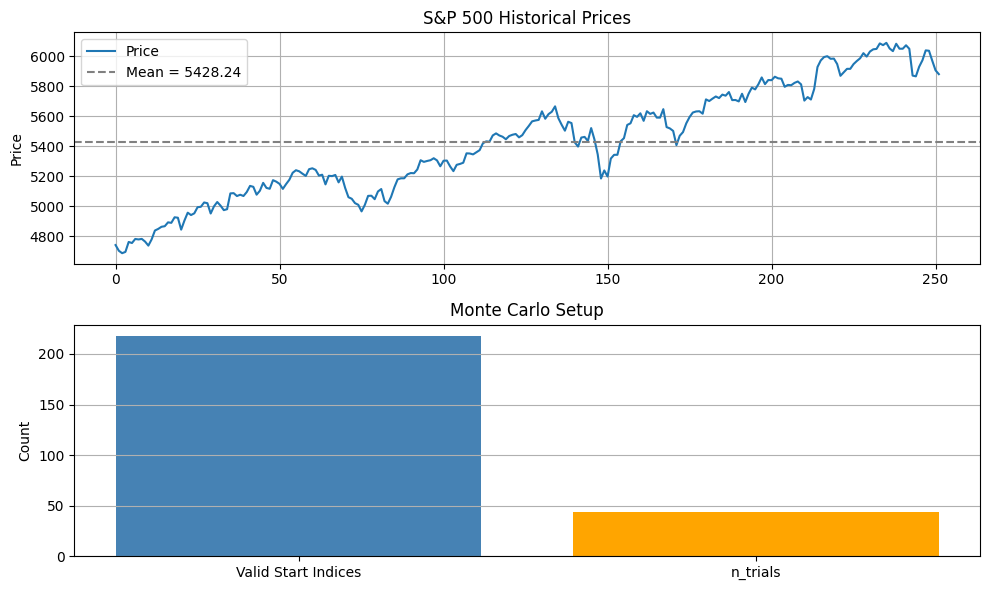

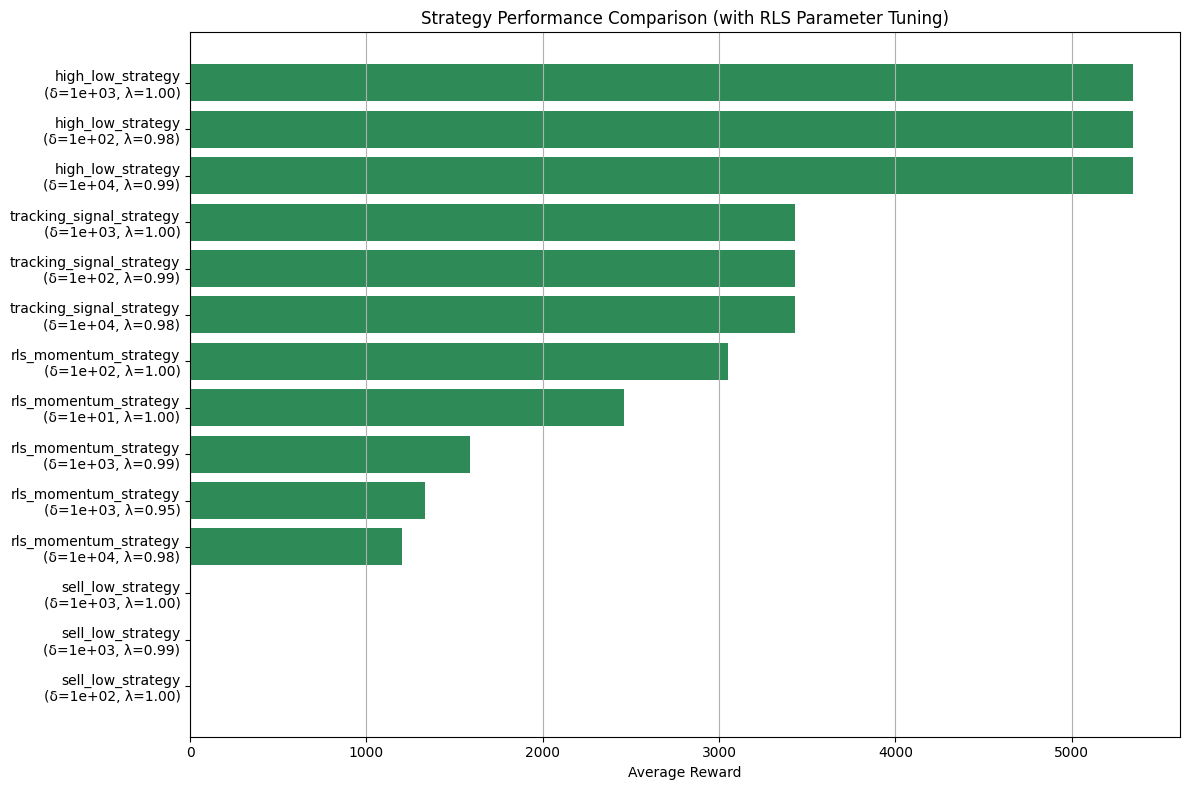

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# --- Minimum data length requirement ---
min_required_length = 10
if len(price_history) < min_required_length:
    raise ValueError(f"Price history too short. Need at least {min_required_length} data points, got {len(price_history)}")

# --- Time horizon setup ---
T = min(30, len(price_history) // 5)

# --- Determine valid starting index range ---
min_start_index = 3
max_start_index = len(price_history) - T - 1
valid_indices_count = max(0, max_start_index - min_start_index)
n_trials = min(44, valid_indices_count)

# --- Compute price statistics ---
price_mean = np.mean(price_history)
price_std = np.std(price_history)

# --- Visualization: Price series and evaluation capacity ---
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Price chart with mean overlay
axs[0].plot(price_history, label="Price")
axs[0].axhline(price_mean, linestyle="--", color="gray", label=f"Mean = {price_mean:.2f}")
axs[0].set_title("S&P 500 Historical Prices")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid(True)

# Bar chart showing available data for simulation
axs[1].bar(["Valid Start Indices", "n_trials"], [valid_indices_count, n_trials], color=["steelblue", "orange"])
axs[1].set_title("Monte Carlo Setup")
axs[1].set_ylabel("Count")
axs[1].grid(axis="y")

plt.tight_layout()
plt.show()

# --- Update tracking strategies with realistic price mean ---
updated_strategy_configs = []
for config in strategy_configs:
    if config["strategy"].__name__ == "tracking_signal_strategy":
        updated_config = config.copy()
        updated_config["params"] = config["params"].copy()
        updated_config["params"]["bar_p_t"] = price_mean
        updated_strategy_configs.append(updated_config)
    else:
        updated_strategy_configs.append(config)

# --- Seed setup and strategy evaluation ---
seed = 42

if n_trials > 0:
    all_results = evaluate_all_strategies(
        price_history=price_history,
        rls_model=rls,
        strategy_configs=updated_strategy_configs,
        T=T,
        n_trials=n_trials,
        seed=seed
    )

    # Visualization of strategy performance
    import pandas as pd
    df_results = pd.DataFrame(all_results)
    df_results.sort_values("avg_reward", ascending=False, inplace=True)
    
    # Create better labels that include RLS parameters
    df_results["strategy_label"] = df_results.apply(
        lambda row: f"{row['strategy']}\n(δ={row['rls_params']['delta']:.0e}, λ={row['rls_params']['lambda']:.2f})",
        axis=1
    )

    plt.figure(figsize=(12, 8))
    plt.barh(df_results["strategy_label"], df_results["avg_reward"], color="seagreen")
    plt.xlabel("Average Reward")
    plt.title("Strategy Performance Comparison (with RLS Parameter Tuning)")
    plt.gca().invert_yaxis()
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.show()
else:
    raise RuntimeError("No valid start indices available. Evaluation skipped.")


In [32]:
best = all_results[0]
print("Best strategy found:")
print("  Name:", best["strategy"])
print("  Strategy params:", best["params"])
print("  RLS params:", best["rls_params"])
print("  Avg reward:", best["avg_reward"])

# Print top 5 strategies for comparison
print("\n" + "="*50)
print("TOP 5 STRATEGIES:")
print("="*50)
for i, result in enumerate(all_results[:5]):
    print(f"{i+1}. {result['strategy']}")
    print(f"   Strategy params: {result['params']}")
    print(f"   RLS params: δ={result['rls_params']['delta']:.0e}, λ={result['rls_params']['lambda']:.3f}")
    print(f"   Avg reward: {result['avg_reward']:.2f}")
    print()

Best strategy found:
  Name: high_low_strategy
  Strategy params: {'theta_low': 0.9, 'theta_high': 1.1}
  RLS params: {'delta': 1000.0, 'lambda': 1.0}
  Avg reward: 5346.6829833984375

TOP 5 STRATEGIES:
1. high_low_strategy
   Strategy params: {'theta_low': 0.9, 'theta_high': 1.1}
   RLS params: δ=1e+03, λ=1.000
   Avg reward: 5346.68

2. high_low_strategy
   Strategy params: {'theta_low': 0.92, 'theta_high': 1.08}
   RLS params: δ=1e+02, λ=0.980
   Avg reward: 5346.68

3. high_low_strategy
   Strategy params: {'theta_low': 0.95, 'theta_high': 1.05}
   RLS params: δ=1e+04, λ=0.990
   Avg reward: 5346.68

4. tracking_signal_strategy
   Strategy params: {'bar_p_t': np.float64(5428.235119047619), 'theta': 0.03}
   RLS params: δ=1e+03, λ=1.000
   Avg reward: 3431.17

5. tracking_signal_strategy
   Strategy params: {'bar_p_t': np.float64(5428.235119047619), 'theta': 0.05}
   RLS params: δ=1e+02, λ=0.990
   Avg reward: 3431.17



🔬 RLS MOMENTUM STRATEGY - Parameter Impact Analysis
Performance ranking:
5. θ=0.010, δ=1e+02, λ=1.000 → Reward: 3050.11
4. θ=0.015, δ=1e+01, λ=1.000 → Reward: 2463.00
3. θ=0.020, δ=1e+03, λ=0.990 → Reward: 1588.20
2. θ=0.025, δ=1e+03, λ=0.950 → Reward: 1334.34
1. θ=0.030, δ=1e+04, λ=0.980 → Reward: 1202.70


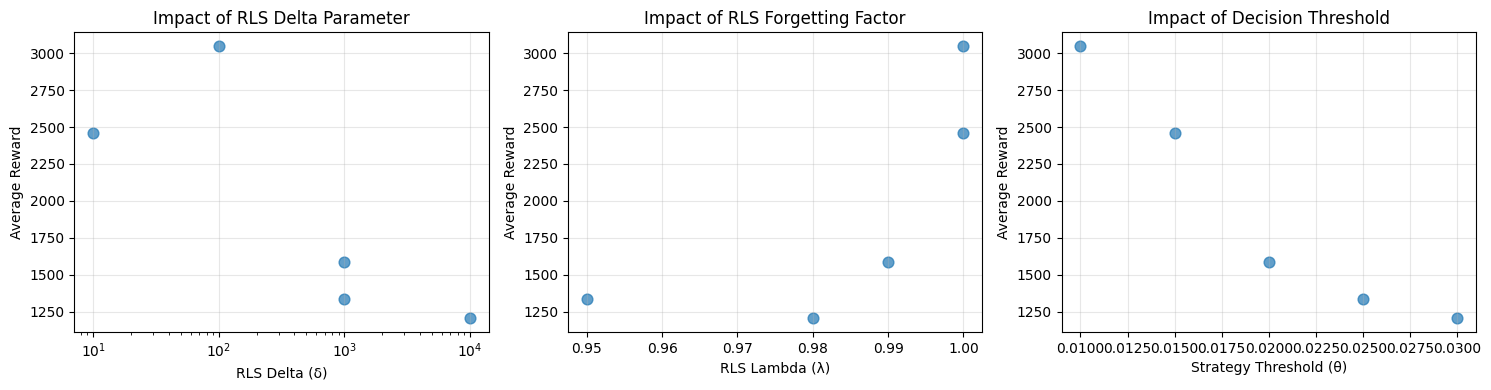


🎯 KEY INSIGHTS:
------------------------------
• Best RLS config: δ=1e+02, λ=1.000
• Worst RLS config: δ=1e+04, λ=0.980
• Performance difference: 1847.41
• Relative improvement: 153.6%


In [33]:
# 📊 Analysis of RLS Parameter Impact

# Filter results to focus on RLS-dependent strategies
rls_dependent_results = [r for r in all_results if r["strategy"] == "rls_momentum_strategy"]

if rls_dependent_results:
    print("🔬 RLS MOMENTUM STRATEGY - Parameter Impact Analysis")
    print("=" * 60)
    
    # Create DataFrame for easier analysis
    rls_df = pd.DataFrame(rls_dependent_results)
    rls_df["delta"] = rls_df["rls_params"].apply(lambda x: x["delta"])
    rls_df["lambda"] = rls_df["rls_params"].apply(lambda x: x["lambda"])
    rls_df["theta"] = rls_df["params"].apply(lambda x: x["theta"])
    
    # Sort by performance
    rls_df_sorted = rls_df.sort_values("avg_reward", ascending=False)
    
    print("Performance ranking:")
    for i, row in rls_df_sorted.iterrows():
        print(f"{len(rls_df_sorted) - list(rls_df_sorted.index).index(i)}. "
              f"θ={row['theta']:.3f}, δ={row['delta']:.0e}, λ={row['lambda']:.3f} "
              f"→ Reward: {row['avg_reward']:.2f}")
    
    # Visualize the parameter impact
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Delta impact
    axes[0].scatter(rls_df["delta"], rls_df["avg_reward"], alpha=0.7, s=60)
    axes[0].set_xlabel("RLS Delta (δ)")
    axes[0].set_ylabel("Average Reward")
    axes[0].set_title("Impact of RLS Delta Parameter")
    axes[0].set_xscale("log")
    axes[0].grid(True, alpha=0.3)
    
    # Lambda impact
    axes[1].scatter(rls_df["lambda"], rls_df["avg_reward"], alpha=0.7, s=60)
    axes[1].set_xlabel("RLS Lambda (λ)")
    axes[1].set_ylabel("Average Reward")
    axes[1].set_title("Impact of RLS Forgetting Factor")
    axes[1].grid(True, alpha=0.3)
    
    # Strategy threshold impact
    axes[2].scatter(rls_df["theta"], rls_df["avg_reward"], alpha=0.7, s=60)
    axes[2].set_xlabel("Strategy Threshold (θ)")
    axes[2].set_ylabel("Average Reward")
    axes[2].set_title("Impact of Decision Threshold")
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Key insights
    print("\n🎯 KEY INSIGHTS:")
    print("-" * 30)
    best_rls = rls_df_sorted.iloc[0]
    worst_rls = rls_df_sorted.iloc[-1]
    
    print(f"• Best RLS config: δ={best_rls['delta']:.0e}, λ={best_rls['lambda']:.3f}")
    print(f"• Worst RLS config: δ={worst_rls['delta']:.0e}, λ={worst_rls['lambda']:.3f}")
    print(f"• Performance difference: {best_rls['avg_reward'] - worst_rls['avg_reward']:.2f}")
    print(f"• Relative improvement: {((best_rls['avg_reward'] / worst_rls['avg_reward']) - 1) * 100:.1f}%")
    
else:
    print("No RLS momentum strategy results found for analysis.")

🎯 FINE-TUNING RLS MOMENTUM STRATEGY
🔍 Grid Search: Testing 50 RLS parameter combinations...
  Config 1/50: δ=1e+01, λ=0.100
  Config 2/50: δ=1e+01, λ=0.325
  Config 3/50: δ=1e+01, λ=0.550
  Config 4/50: δ=1e+01, λ=0.775
  Config 5/50: δ=1e+01, λ=1.000
  Config 6/50: δ=1e+03, λ=0.100
  Config 7/50: δ=1e+03, λ=0.325
  Config 8/50: δ=1e+03, λ=0.550
  Config 9/50: δ=1e+03, λ=0.775
  Config 10/50: δ=1e+03, λ=1.000
  Config 11/50: δ=2e+03, λ=0.100
  Config 12/50: δ=2e+03, λ=0.325
  Config 13/50: δ=2e+03, λ=0.550
  Config 14/50: δ=2e+03, λ=0.775
  Config 15/50: δ=2e+03, λ=1.000
  Config 16/50: δ=3e+03, λ=0.100
  Config 17/50: δ=3e+03, λ=0.325
  Config 18/50: δ=3e+03, λ=0.550
  Config 19/50: δ=3e+03, λ=0.775
  Config 20/50: δ=3e+03, λ=1.000
  Config 21/50: δ=4e+03, λ=0.100
  Config 22/50: δ=4e+03, λ=0.325
  Config 23/50: δ=4e+03, λ=0.550
  Config 24/50: δ=4e+03, λ=0.775
  Config 25/50: δ=4e+03, λ=1.000
  Config 26/50: δ=6e+03, λ=0.100
  Config 27/50: δ=6e+03, λ=0.325
  Config 28/50: δ=6e+03, λ

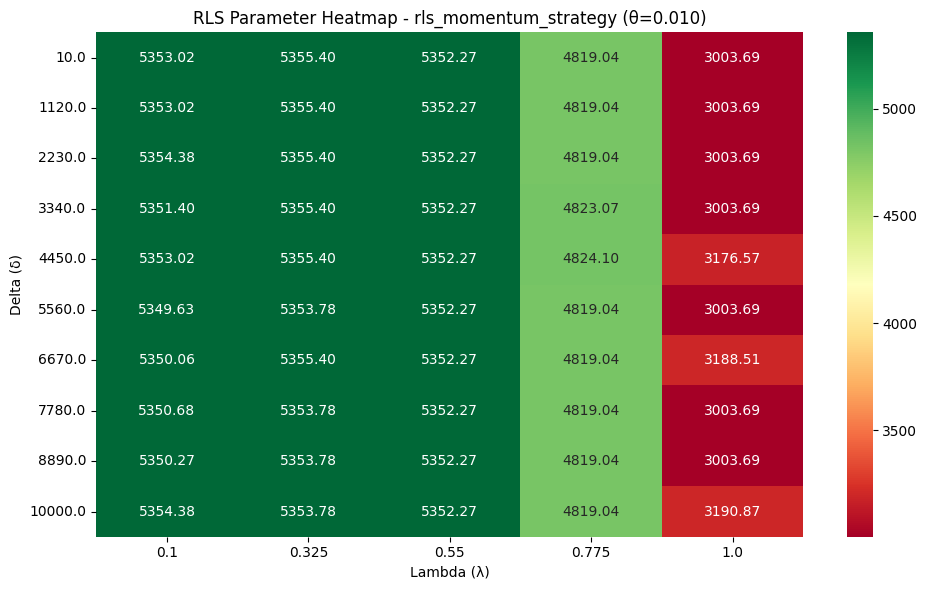


🎯 OPTIMAL RLS CONFIGURATION:
   δ = 1e+01
   λ = 0.325
   Expected reward = 5355.40


In [34]:
def grid_search_rls_parameters(
    price_history: np.ndarray,
    base_rls_model: BaseEstimator,
    strategy: Callable,
    strategy_params: dict,
    delta_values: list,
    lambda_values: list,
    T: int,
    n_trials: int = 50,
    seed: int = 42
) -> pd.DataFrame:
    """
    Perform grid search over RLS parameters for a given strategy.
    
    Args:
        price_history: Historical price data
        base_rls_model: Base RLS model to copy
        strategy: Strategy function to evaluate
        strategy_params: Fixed strategy parameters
        delta_values: List of delta values to test
        lambda_values: List of lambda values to test
        T: Time horizon
        n_trials: Number of Monte Carlo trials per configuration
        seed: Random seed
        
    Returns:
        DataFrame with results sorted by performance
    """
    results = []
    total_configs = len(delta_values) * len(lambda_values)
    config_count = 0
    
    print(f"🔍 Grid Search: Testing {total_configs} RLS parameter combinations...")
    
    for delta in delta_values:
        for lambda_val in lambda_values:
            config_count += 1
            print(f"  Config {config_count}/{total_configs}: δ={delta:.0e}, λ={lambda_val:.3f}")
            
            try:
                avg_reward = monte_carlo_evaluate(
                    price_history=price_history,
                    rls_model=deepcopy(base_rls_model),
                    strategy=strategy,
                    strategy_kwargs=strategy_params,
                    T=T,
                    n_trials=n_trials,
                    seed=seed,
                    rls_delta=delta,
                    rls_lambda=lambda_val
                )
                
                results.append({
                    "delta": delta,
                    "lambda": lambda_val,
                    "avg_reward": avg_reward,
                    "strategy": strategy.__name__,
                    "strategy_params": strategy_params
                })
                
            except Exception as e:
                print(f"    ❌ Failed: {e}")
                continue
    
    # Convert to DataFrame and sort by performance
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values("avg_reward", ascending=False)
        print(f"\n✅ Grid search completed! Best performance: {df.iloc[0]['avg_reward']:.2f}")
    else:
        print("❌ No valid results from grid search")
    
    return df

# Example usage: Fine-tune the RLS momentum strategy
print("🎯 FINE-TUNING RLS MOMENTUM STRATEGY")
print("=" * 50)

# Define parameter grids

# define a better delta grid:
delta_grid = np.linspace(1e1, 1e4, 10)
lambda_grid = np.linspace(0.10, 1.0, 5)  # More realistic range for lambda

# Fine-tune the best performing threshold
best_momentum_config = next(
    (r for r in all_results if r["strategy"] == "rls_momentum_strategy"), 
    None
)

if best_momentum_config:
    best_theta = best_momentum_config["params"]["theta"]
    
    # Perform grid search
    grid_results = grid_search_rls_parameters(
        price_history=price_history,
        base_rls_model=rls,
        strategy=rls_momentum_strategy,
        strategy_params={"theta": best_theta},
        delta_values=delta_grid,
        lambda_values=lambda_grid,
        T=T,
        n_trials=30,  # Reduced for faster execution
        seed=42
    )
    
    if not grid_results.empty:
        # Display top results
        print("\n🏆 TOP 5 RLS CONFIGURATIONS:")
        print("-" * 40)
        for i, row in grid_results.head().iterrows():
            print(f"{len(grid_results) - list(grid_results.index).index(i)}. "
                  f"δ={row['delta']:.0e}, λ={row['lambda']:.3f} "
                  f"→ Reward: {row['avg_reward']:.2f}")
        
        # Create heatmap visualization
        pivot_table = grid_results.pivot_table(
            values='avg_reward', 
            index='delta', 
            columns='lambda', 
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 6))
        import seaborn as sns
        sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn')
        plt.title(f'RLS Parameter Heatmap - {rls_momentum_strategy.__name__} (θ={best_theta:.3f})')
        plt.xlabel('Lambda (λ)')
        plt.ylabel('Delta (δ)')
        plt.tight_layout()
        plt.show()
        
        # Extract optimal parameters
        optimal_config = grid_results.iloc[0]
        print(f"\n🎯 OPTIMAL RLS CONFIGURATION:")
        print(f"   δ = {optimal_config['delta']:.0e}")
        print(f"   λ = {optimal_config['lambda']:.3f}")
        print(f"   Expected reward = {optimal_config['avg_reward']:.2f}")
        
else:
    print("❌ No RLS momentum strategy results found for fine-tuning")

In [35]:
def compare_policies_with_ci(
    p_o: float,
    T: int,
    strategy_A: Callable,
    kwargs_A: dict,
    strategy_B: Callable,
    kwargs_B: dict,
    n_simulations: int = 1000,
    seed: int = None
) -> Tuple[float, float, float]:
    """
    Compares two policies using common random numbers and computes a 95% confidence interval
    for the difference in their average rewards.

    Args:
        p_o (float): Initial asset price.
        T (int): Time horizon.
        strategy_A (Callable): First strategy function.
        kwargs_A (dict): Parameters for the first strategy.
        strategy_B (Callable): Second strategy function.
        kwargs_B (dict): Parameters for the second strategy.
        n_simulations (int): Number of common simulations to use.
        seed (int): Random seed for reproducibility.

    Returns:
        Tuple[float, float, float]: (mean_diff, lower_bound, upper_bound)
    """
    if seed is not None:
        np.random.seed(seed)

    diffs = []

    for _ in range(n_simulations):
        # Reset price and randomness
        p_t = p_o
        path_rng = np.random.normal(0, 0.5, size=T+1)  # fixed price path for both

        # Simulate with strategy A
        R_t = 1
        reward_A = 0
        for t in range(T + 1):
            x_t = strategy_A(p_t, R_t, t=t, T=T, **kwargs_A)
            reward_A += p_t * x_t
            R_t -= x_t
            if R_t == 0:
                break
            p_t = max(p_t + path_rng[t], 0.01)

        # Reset for strategy B
        p_t = p_o
        R_t = 1
        reward_B = 0
        for t in range(T + 1):
            x_t = strategy_B(p_t, R_t, t=t, T=T, **kwargs_B)
            reward_B += p_t * x_t
            R_t -= x_t
            if R_t == 0:
                break
            p_t = max(p_t + path_rng[t], 0.01)

        diffs.append(reward_A - reward_B)

    diffs = np.array(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1)
    ci_95 = 1.96 * std_diff / np.sqrt(n_simulations)

    lower_bound = mean_diff - ci_95
    upper_bound = mean_diff + ci_95

    return mean_diff, lower_bound, upper_bound


In [36]:
mean_diff, ci_low, ci_high = compare_policies_with_ci(
    p_o=1.0,
    T=20,
    strategy_A=sell_low_strategy,
    kwargs_A={"theta": 0.95},
    strategy_B=tracking_signal_strategy,
    kwargs_B={"bar_p_t": 1.0, "theta": 0.05},
    n_simulations=10000,
    seed=42
)

print(f"Mean difference in reward: {mean_diff:.4f}")
print(f"95% confidence interval: ({ci_low:.4f}, {ci_high:.4f})")


Mean difference in reward: -0.3383
95% confidence interval: (-0.3607, -0.3159)
